# Consistent Bayes: ODE Examples
---

Copyright 2018 Michael Pilosov


### Import Libraries


In [22]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
%matplotlib inline
# %matplotlib notebook
# plt.xkcd(scale=1, length=1000, randomness=0)
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *
import matplotlib.colors as colors

# import numpy as np
from scipy.integrate import odeint

In [23]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 20, 10

In [24]:
problem = 'ed'

# Example Summary

---

The second example is defined by the model for a harmonic oscillator given by the initial value problem  

\begin{equation}
	\begin{cases}
		\frac{d^2u}{dt^2} &= -\lambda_2^2 u, \ t>0, \\
		u(0) &= \lambda_1. 
	\end{cases}
\end{equation}

Choosing a particular parameter $\lambda=(\lambda_1,\lambda_2)\in\Lambda\subset[-1,1]\times\mathbb{R}^+$ corresponds to fixing an initial condition, $\lambda_1\in[-1,1]$, and frequency of oscillation, $\lambda_2$, where we again assume that $\lambda_2>0$.

The solution to the above is
\begin{equation}
	u(t) = \cos(\lambda_2 t + \arccos(\lambda_1)).
\end{equation}

---
## Define Functions

In [25]:
def MSE_generator(model, obs_data, sigma=None):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        M = len(obs_data)
        predictions = model(inputs)
        assert predictions.shape[1] == M
        residuals = predictions - obs_data
        if sigma is not None:
            QoI = (1./M)*np.sum( (residuals/sigma)**2, axis=1 )   # MSE
        else:
            QoI = (1./M)*np.sum( (residuals/obs_data)**2, axis=1 )  # MRSE
        return QoI
    return QoI_fun

if problem == 'ed':
    # The model of the exponential decay
    def makemodel(t):
        def model(lam = np.array([[0.5, 0.5]]) ):
            QoI = lam[:,0].reshape(-1,1)*np.exp(np.outer(lam[:,1], -t))
            if QoI.shape[0] == 1:
                return QoI.ravel() # this allows support for simpler 1D plotting.
            else:
                return QoI
        return model
elif problem == 'ho':
    # The model of the harmonic oscillator 
    def makemodel(t):
        def model(lam = np.array([[0, 1]]) ):
    #         return np.cos(lam[:,1]*t + np.arccos(lam[:,0]) )
            QoI = np.cos(np.outer(lam[:,1],t) + np.arccos(lam[:,0]).reshape(-1,1) )
            if QoI.shape[0] == 1:
                return QoI.ravel() # this allows support for simpler 1D plotting.
            else:
                return QoI
        return model



In [26]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
num_observations = 50 # how many observations are you able to make?
start_time = 1
end_time = 5
####

t = np.linspace(start_time, end_time, num_observations)
model = makemodel(t)
u = model()

## Get a sense of the variation in the system you are studying



saving saveimgs/HO/HO_signal-50_t_0_5_st1_5.png


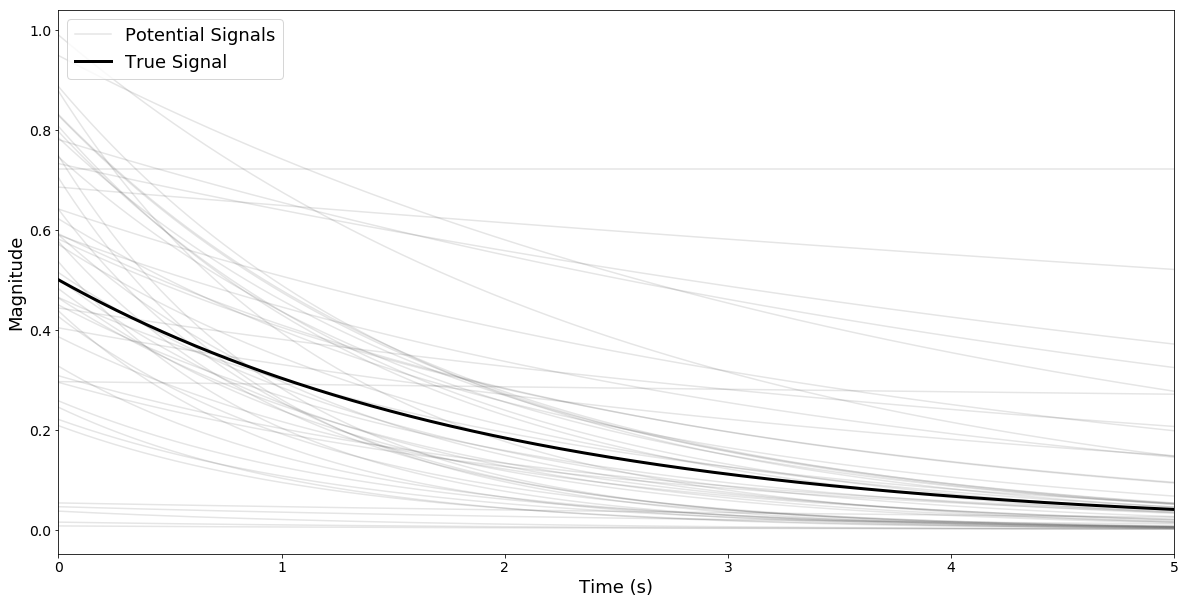

In [27]:
n = 50
lam = np.random.random(size=(n,2))
if problem == 'ho':
    lam[:,0] = 0.5*lam[:,0] - 0.25
    lam[:,1] = lam[:,1] + 0.5
elif problem == 'ed':
    pass # keep as is.

sd_test_n = 0.025
# sd_test_u = 0.1
# sd_test_c = 0.1
mintime = 0
maxtime = 5
tt = np.linspace(mintime, maxtime, 1000)
m = makemodel(tt)
ui = m(lam)

um = m()
plt.cla()
show_obs = False
# Plotting the default IR results from the epidemic_IR function.
for i in range(n):
    d = ui[i,:]
    if i == n-1:
        plt.plot(tt, d, c='k', alpha=5/n, label='Potential Signals')
    else:
        plt.plot(tt, d, c='k', alpha=5/n) # I
    
# plt.scatter(t, u + np.random.randn(num_observations)*sd_test_n, s=50, c='k', label='Normal', alpha=0.5)
# plt.scatter(t, u + (np.random.rand(num_observations)-0.5)*sd_test_u,c='b', s=5, label='Uniform')
# plt.scatter(t, u + (np.random.standard_cauchy(num_observations))*sd_test_c,c='g', s=50, marker='x',label='Cauchy')
plt.plot(tt, um, c='k', lw=3, ls='-', label='True Signal')
if show_obs:
    plt.scatter(t, u + np.random.randn(num_observations)*sd_test_n, marker='x', s=50, c='k', label='{} Observations'.format(num_observations), alpha=1)

plt.legend(fontsize=18,loc='upper left')
plt.ylabel('Magnitude', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
# plt.ylim([-.25,1.25])
plt.xlim([0,5])
ftype = 'png'
if show_obs:
    summary_save_str = "saveimgs/HO/HO_%d_r-%d_obs-%de-3_sd-t_%d_%d_st%d_%d.%s"%(n, num_observations, 1000*sd_test_n, mintime, maxtime, start_time, end_time, ftype)
else:
    summary_save_str = "saveimgs/HO/HO_signal-%d_t_%d_%d_st%d_%d.%s"%(n, mintime, maxtime, start_time, end_time, ftype)

print("saving " + summary_save_str)
plt.savefig(summary_save_str)
plt.show()

--- 

# Define Prior Measure $P_\Lambda$


In [28]:
input_dim = 2 # Specify input space dimension (n) -- this is a handle that the widgets depend on.
num_samples = int(1E4) # number of input samples (N)
s_set = sample.sample_set(size=(num_samples, input_dim))

if problem == 'ed':
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=0) # initial condition
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=1) # frequency
elif problem == 'ho':
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -0.25, 'scale': 0.5}, dim=0) # initial condition
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': .5, 'scale': 1}, dim=1) # frequency

s_set.generate_samples()
lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

In [29]:
# widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
#                     N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#                     eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
#                     view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
#                     view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [30]:
u_true = model() # t as a subscript stands for "truth"
sd_true = sd_test_n
sd_guess = sd_true

# sd_true = 0.05
# sd_guess = 0.025

obs_data = u_true + np.random.randn(int(num_observations))*sd_true
# obs_data = u_true + np.random.standard_cauchy(int(num_observations))*sd_true
# obs_data = u_true + (np.random.rand(int(num_observations))-0.5)*sd_true

PtO_fun = MSE_generator(model, obs_data, sd_guess)

In [31]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples

# This is how we handle trying to infer the dimension based on what the map put out.
# You can delete this once you are certain your model is correctly defined.
try:
    output_dim = D.shape[1] # if your function was coded correctly, you should have an (n, d) data space.
except IndexError:
    print(Warning("Warning: Your map might be returning the wrong dimensional data."))
    try:
       output_dim = D.shape[0] 
    except IndexError:
        print(Warning("Warning: Guessing it's 1-dimensional."))
        output_dim = 1
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

dimensions :  lambda = (10000, 2)   D = (10000, 1)


# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [32]:
# Interactive Marginal Visualization
# p_set.compute_pushforward_dist(mirror=False, kwds={'kernel': 'gaussian', 'bandwidth': .25})
# p_set.compute_pushforward_dist(mirror=False, kwds={'kernel': 'gaussian', 'bandwidth': 5})
p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

In [33]:
# widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
#         N = widgets.IntSlider(value=10000, min = 100, max=10000, step=100, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown", continuous_update=False),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

# Define Observed Probability Measure $P_\mathcal{D}$

In [34]:
p_set.set_observed_dist('gamma', {'a':num_observations/2, 'scale':2/num_observations}, dim=0)
# 
# p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)
# p_set.set_observed_dist('normal', {'loc': 0, 'scale': 0.05}, dim=0)
# p_set.set_observed_dist('uniform', {'loc': 0, 'scale': 0.0025}, dim=0)

obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

# widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
#         N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))
xx = np.linspace(-1,10,500).reshape(-1,1)
obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.
zz = pf_dist.pdf(xx)
yy = obs_dist.pdf(xx)

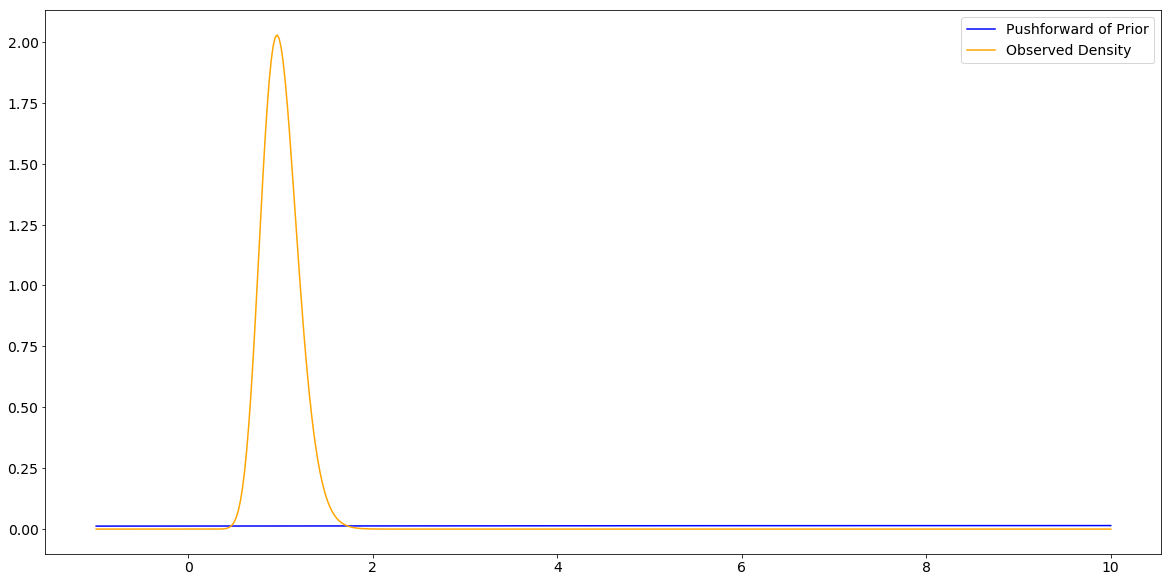

In [35]:
plt.plot(xx, zz, c='blue',label='Pushforward of Prior')
plt.plot(xx, yy,c='orange',label='Observed Density')
# plt.ylim([0,0.05])
plt.legend()
plt.show()

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [36]:
p_set.set_ratio()
eta_r = p_set.ratio
s_set.seed = 11
solve.problem(p_set)

In [37]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
if problem == 'ho':
    lam_true = np.array([0, 1])
elif problem == 'ed':
    lam_true = np.array([0.5, 0.5])
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 266 = 2.66%


## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


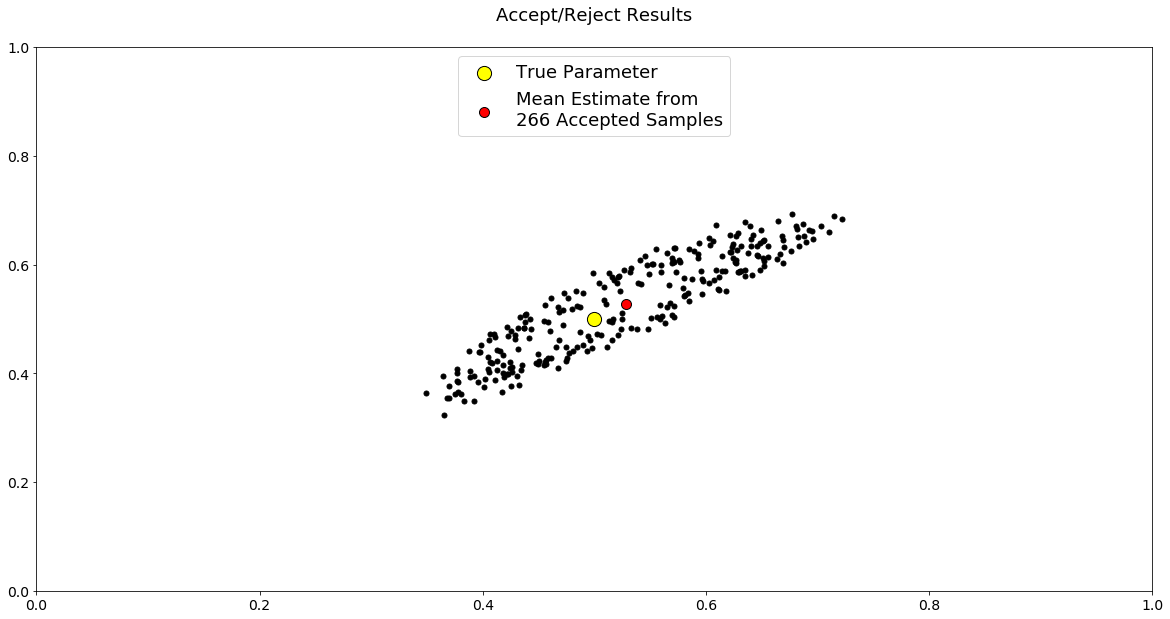

In [38]:
# widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
#         N = widgets.IntSlider(value=num_accept/2+1, min = 2, max=num_accept, step=1, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.
plt.figure()
plt.title("Accept/Reject Results\n", fontsize=18)
plt.scatter(lam_accept[:,0], lam_accept[:,1], c='black', s=25)
plt.scatter(lam_true[0],lam_true[1], c='yellow', edgecolor='black', s=200, label='True Parameter')
# plt.scatter(lam[:,0], lam[:,1], c='gray', s=10)

plt.scatter(lam_accept[:,0].mean(), lam_accept[:,1].mean(),  c='red', edgecolor='black', s=100, label='Mean Estimate from\n{} Accepted Samples'.format(num_accept))
plt.legend(loc='upper center', fontsize=18)
if problem == 'ho':
    plt.xlim([-.25, .25])
    plt.ylim([0.5, 1.5])
if problem == 'ed':
    plt.xlim([0, 1])
    plt.ylim([0, 1])
plt.show()

# Alternative Visualization Approach - High Fidelity Mesh Plot (expensive)

Now that we have constructed the posterior distribution, we can evaluate it at whatever set of samples we want, so we plot it directly, rather than use Accept/Reject. This is done at the cost of a lot of model runs.


In [39]:
nbins = 200
# mins = np.min(p_set.input.samples,axis=0)
# maxs = np.max(p_set.input.samples,axis=0)

if problem == 'ho':
    mins = np.array([-0.25, 0.5])
    maxs = np.array([0.5, 1.5])
elif problem == 'ed':
    mins = np.array([0.25, 0.25]) 
    maxs = np.array([0.75, 0.75])

X = ngrid(nbins, mins, maxs)
post_eval = p_set.evaluate_posterior(X)
# post_eval = p_set.compute_ratio(PtO_fun(X))*p_set.input.dist.pdf(X)

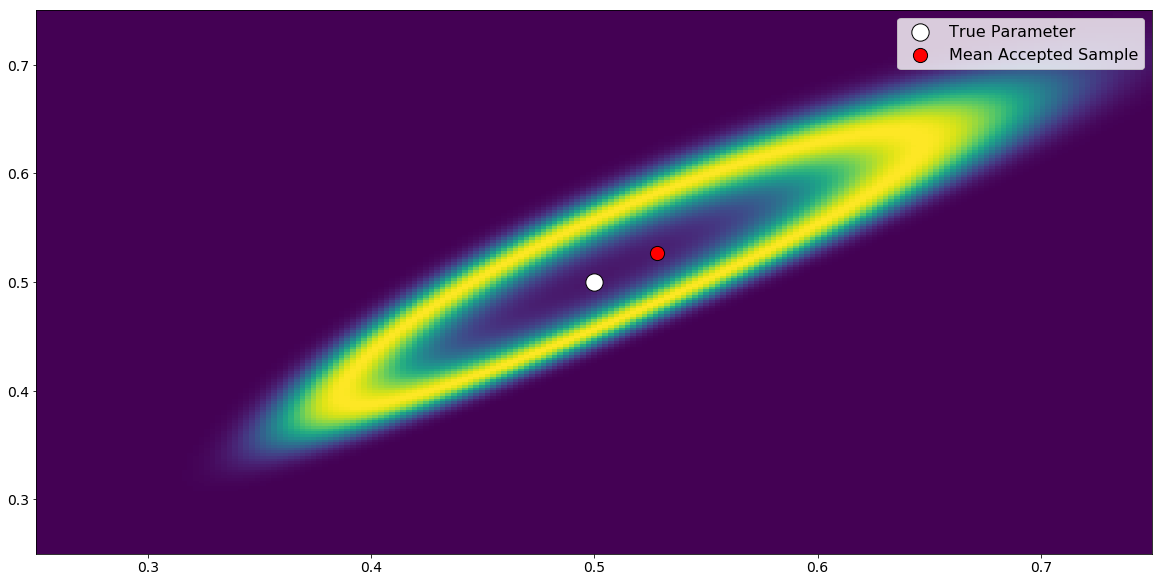

In [40]:
# Make the plot
xi = X[:,0].reshape(nbins, nbins)
yi = X[:,1].reshape(nbins, nbins)
zi = post_eval.reshape(nbins, nbins)
plt.pcolormesh(xi, yi, zi)
plt.scatter(lam_true[0],lam_true[1], c='white', edgecolor='black', s=300, label='True Parameter')
plt.scatter(lam_accept[:,0].mean(), lam_accept[:,1].mean(),  c='red', edgecolor='black', s=200, label='Mean Accepted Sample')
# plt.scatter(X[inds_new,0].mean(), X[inds_new,1].mean(),  c='yellow', edgecolor='black', s=100, label='Mean Estimate') # can run after the cell below is executed
plt.legend(loc='upper right', fontsize=16)
if problem == 'ho':
    plt.xlim([-.25, 0.25])
    plt.ylim([0.5, 1.5])
if problem == 'ed':
    plt.xlim([0.25, 0.75])
    plt.ylim([0.25, 0.75])
plt.show()
# ?plt.pcolormesh

## Perform accept/reject with the samples we just used for the high-fidelity plot.
(because why not?)

In [ ]:
plot_new = True 
XX = ngrid(nbins, mins, maxs)
# Perform accept/reject on that grid you see plotted above.
if plot_new:
    Y = PtO_fun(XX)
    inds_new = solve.perform_accept_reject(XX, p_set.compute_ratio(Y))
    print('Num accepted:', len(inds_new))
    new_accepted_in = XX[inds_new,:]
    new_accepted_out = Y[inds_new].reshape(-1,1)
    new_num_accept = len(inds_new)

In [ ]:
if plot_new:
    # Make the plot
    xi = XX[:,0].reshape(nbins, nbins)
    yi = XX[:,1].reshape(nbins, nbins)
    post_eval2 = p_set.evaluate_posterior(XX)
    zi = post_eval2.reshape(nbins, nbins)
    plt.pcolormesh(xi, yi, zi)
    plt.scatter(lam_true[0],lam_true[1], c='white', edgecolor='black', s=300, label='True Parameter')
    plt.scatter(lam_accept[:,0].mean(), lam_accept[:,1].mean(),  c='red', edgecolor='black', s=200, label='Mean Accepted Sample')
    plt.scatter(XX[inds_new,0].mean(), XX[inds_new,1].mean(),  c='yellow', edgecolor='black', s=100, label='Mean Estimate') # can run after the cell below is executed
    plt.legend(loc='lower right', fontsize=16)
    plt.show()
    print('Abs Error in Parameter and MAP:', [*np.abs( lam_true - np.mean(X[inds_new,:],axis=0) )] )
    print('Param. Test Stats for Gamma Dist:', [*np.abs( p_set.observed_dist.mean()-np.mean(Y[inds_new],axis=0))/p_set.observed_dist.mean() , *np.abs( p_set.observed_dist.std()-np.std(Y[inds_new],axis=0))/p_set.observed_dist.std()])


---
# Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

In [ ]:
xxi = np.linspace(0,4,100)
plt.plot(xxi, p_set.observed_dist.pdf(xxi), label='Observed', ls=':')
dy = distributions.skde(data=p_set.output.samples[accept_inds,:], **{'kernel': 'gaussian', 'bandwidth': 0.25})
plt.plot(xxi, dy.pdf(xxi), label='Pushforward of Posterior - {} AS Originally'.format(len(accept_inds)));
if plot_new:
    dyy = distributions.skde(data=new_accepted_out, **{'kernel': 'gaussian', 'bandwidth': 0.25})
    plt.plot(xxi, dyy.pdf(xxi), label='Pushforward of Posterior - {} AS from Refined Eyeball Run'.format(len(inds_new)))

plt.legend(loc='best')
plt.xlabel('Response')
plt.ylabel('Relative Likelihood')
plt.title('Pushforward of Posterior')
plt.show()

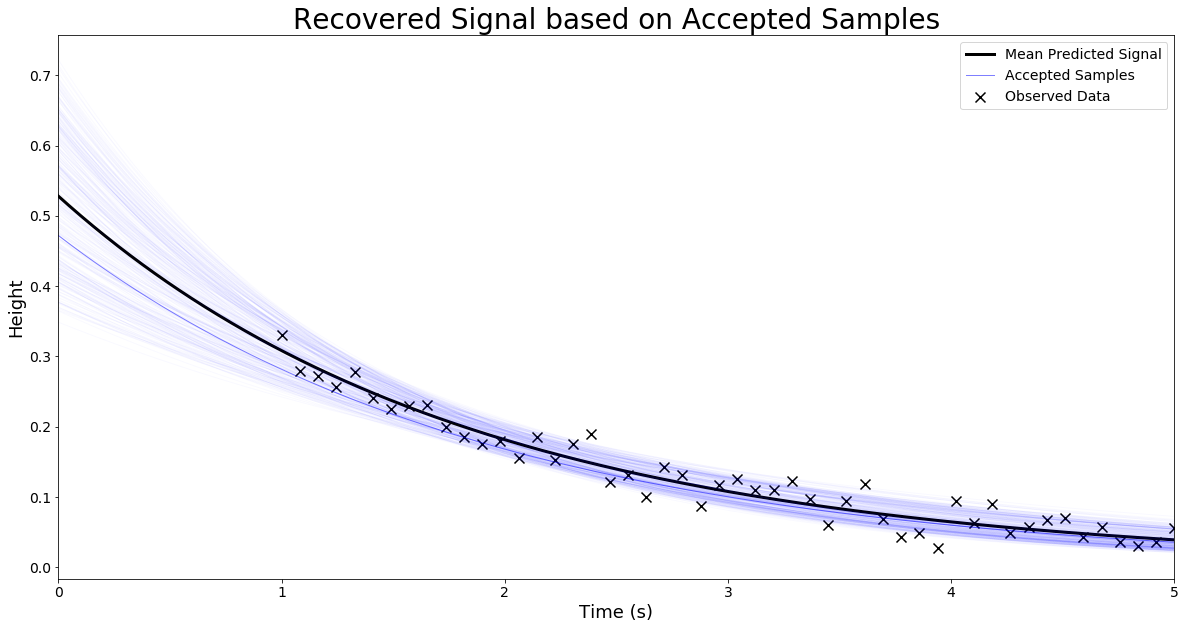

In [41]:
show_prior = False # show the potential signals?
u_acc = m(lam_accept)

plt.scatter(t, obs_data, marker='x', c='k', s=100, label='Observed Data')

dd = np.mean(u_acc, axis=0)
plt.plot(tt, dd, c='k', alpha=1, lw=3, label='Mean Predicted Signal')

for i in range(u_acc.shape[0]):
    d = u_acc[i,:]
    if i==1:
        plt.plot(tt, d, c='b', alpha=0.5, lw=1, label='Accepted Samples')
    else:
        plt.plot(tt, d, c='b', alpha=0.025, lw=1)

if show_prior: 
    for i in range(n):
        d = ui[i,:]
        if i == n-1:
            plt.plot(tt, d, c='k', alpha=5/n, label='Potential Signals')
        else:
            plt.plot(tt, d, c='k', alpha=5/n) # I

plt.ylabel('Height', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.title('Recovered Signal based on Accepted Samples', fontsize=28)
plt.legend(fontsize=18,loc='upper left')
plt.xlim([0,5])
plt.savefig('recovered{}.png'.format(problem.upper()))
plt.legend()
plt.show()

In [ ]:
# widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
#         N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

## Pushforward of Posterior:

In [ ]:
# widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
#         N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant", continuous_update=False),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


## Verify our parametric test statistics.
Let's see if the pushforward of the posterior results in a sample mean and standard deviation that are close to the observed.

In [ ]:
# [np.mean(D[accept_inds,:]), np.std(D[accept_inds,:])]

In [ ]:
# [p_set.observed_dist.mean(), p_set.observed_dist.std()]

Now go back to the [Define Functions](#Define-Functions) and change the distribution on the prior or choose another example problem.